In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

url_1 = 'https://media.githubusercontent.com/media/takanju/wids_datathon_2021/master/Data/TrainingWiDS2021.csv'
url_2 = 'https://media.githubusercontent.com/media/takanju/wids_datathon_2021/master/Data/UnlabeledWiDS2021.csv'

In [4]:
# Splitted data to make same shape of both test and train so that we can apply pre processing on both
# Ref : https://www.kaggle.com/siavrez/2020fatures
medical_data = pd.read_csv(url_1, error_bad_lines=False, index_col=0)
train = medical_data.copy()
test_df = pd.read_csv(url_2, error_bad_lines=False, index_col=0)
y = medical_data["diabetes_mellitus"]
del medical_data['diabetes_mellitus']

Exploratory Data Analysis (EDA)

In [5]:
train.shape

(130157, 180)

In [6]:
# what data types how many cols
medical_data.dtypes.value_counts()

float64    157
int64       16
object       6
dtype: int64

In [7]:
# Percentage of missing values 

pd.DataFrame(train.isna().sum()*100/len(train))

,0
encounter_id,0.000000
hospital_id,0.000000
age,3.832295
bmi,3.449680
elective_surgery,0.000000
...,...
immunosuppression,0.000000
leukemia,0.000000
lymphoma,0.000000
solid_tumor_with_metastasis,0.000000


# Pre processing by Aishwarya

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def preProcessing1(df: pd.DataFrame, y:pd.Series) -> pd.DataFrame:
  columns=df.columns

  #dropping column which are either irrelevant or around 50% of missing values
  df=df.drop(['encounter_id', 'hospital_id', 'icu_id', 'albumin_apache','bilirubin_apache','fio2_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache', 'urineoutput_apache'], axis=1)

  #separating categorical & numerical features
  df_cat = df.select_dtypes("object")
  df_num = df.select_dtypes("number")
  cat_cal = df_cat.columns
  num_cal = df_num.columns
  
  #imputing categorical features by mode
  impute_size1=SimpleImputer(strategy="most_frequent") 
  df_cat = impute_size1.fit_transform(df_cat)
  df_cat = pd.DataFrame(df_cat, columns = cat_cal)

  #imputing numerical features by mean
  impute_size2=SimpleImputer(missing_values=np.nan, strategy="mean") 
  df_num = impute_size2.fit_transform(df_num)
  df_num = pd.DataFrame(df_num, columns = num_cal)

  #concatenating both categorical & numerical features
  df = df_cat.join(df_num)
  return df, [impute_size1, impute_size2 ]
  
  #Standardization
  scaler = StandardScaler()
  scaled_df = scaler.fit_transform(df_num)
  df_num_scale = pd.DataFrame(data=scaled_df, columns=columns)

  #One Hot Encoding
  columnTransformer = ColumnTransformer([('encoder',
                                        OneHotEncoder(),
                                        [0])],
                                     remainder='passthrough')
  onehotencoder = OneHotEncoder()
  df_cat_encod = np.array(columnTransformer.fit_transform(df_cat), dtype = np.str)
  
  return df, [impute_size1, impute_size2, scaler, df_cat_encod ]



# Pre processing by Anjali

In [9]:
#!pip install tqdm
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy import stats, special
import pandas as pd
import numpy as np
import os
import warnings
warnings.simplefilter("ignore")

# Ref: https://www.kaggle.com/shashankasubrahmanya/missing-data-imputation-using-regression

# filling missing values based on linear regression and the most correlated variables
# linear regression -> F-test (which columns are mostly related with the given target column, other than "diabetes")
# Multi-colinearity
# target = diabetes
# Remove features which has more than 50% percentage of missing values
# Return reduced dataset

# Linear Regression
def fillna_using_linear_model(df: pd.DataFrame):
    fea_cols=[]
    for col in df.columns:
        if df[col].dtype=='float64':
            fea_cols.append(col)

    correl = df[fea_cols].corr()

    for col in tqdm(fea_cols):
        nan_ratio = df[col].isnull().sum() / df.shape[0]
        if nan_ratio > 0:
            best_nan_ratio = nan_ratio
            best_col = None
            for id in correl.loc[(correl[col] > 0.7) | (correl[col] < -0.7), col].index:
                nan_temp_ratio = df[id].isnull().sum() / df.shape[0]
                if best_nan_ratio > nan_temp_ratio:
                    best_nan_ratio = nan_temp_ratio
                    best_col = id
            if best_col != None:
                sub = df[[col, best_col]].copy()
                sub = sub.dropna()
                reg = LinearRegression(fit_intercept=True).fit(np.expand_dims(sub[best_col], axis=1), sub[col])
                print(reg.score(np.expand_dims(sub[best_col], axis=1), sub[col]))
                if reg.score(np.expand_dims(sub[best_col], axis=1), sub[col])>0.7:
                    if df.loc[(~df[best_col].isnull()) & (df[col].isnull()), col].shape[0] > 0:
                        df.loc[(~df[best_col].isnull()) & (df[col].isnull()), col] = \
                        reg.predict(np.expand_dims(df.loc[(~df[best_col].isnull()) & (df[col].isnull()), best_col], axis=1))

    return df


def preProcessing2(df: pd.DataFrame, y:pd.Series) -> pd.DataFrame:
  columns=df.columns

# Replace values such as +,- ininity with nan
  df = df.replace([np.inf, -np.inf], np.nan)

# Linear regression
  linReg = fillna_using_linear_model(df)

# Simple Imputing
  imputer = SimpleImputer(strategy="mean")
  imputed_df = pd.DataFrame(imputer.fit_transform(linReg.values))

# Standardization
  scaler = StandardScaler()
  scaled_df = scaler.fit_transform(imputed_df)
  df= pd.DataFrame(data=scaled_df, columns=columns)
  
  return df, [imputer, scaler]

# dd = preProcessing2(medical_data.copy(), y)
# dd


# Pre processing by Jae Woong

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # MICE 
from sklearn.preprocessing import StandardScaler
# from discretization import MDLP
# from mdlp.discretization import MDLP

def preProcessing3(df: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
  columns = df.columns

  # Log transform for skewing data
  # https://stats.stackexchange.com/questions/267078/why-is-skewed-data-not-preferred-for-modelling
  # https://stats.stackexchange.com/questions/299154/the-benefit-of-unskewing-skewed-data
  logs_transform_list = ['d1_bilirubin_min', 'd1_bilirubin_max', 'd1_glucose_max', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min']
  df[logs_transform_list] = np.log2(df[logs_transform_list])

  # Simple Imputing
  imputer = SimpleImputer(strategy="mean")
  imputed_df = imputer.fit_transform(df.values)

  # Standardization
  scaler = StandardScaler()
  imputed_scaled_df = scaler.fit_transform(imputed_df)

  df = pd.DataFrame(columns=columns, data=imputed_scaled_df)

  return df, [{"columns": logs_transform_list, "transform": np.log2}, imputer, scaler]

# Pre processing by Uma

In [11]:
#ref: https://www.kaggle.com/lhagiimn/7th-place-solution-wids-2021
#ref:https://www.kaggle.com/letianyu/wids-2021-notebook

def remove_NaN_Values(df, threshold):
    # store the name of columns
    # drop the same for the test set (later)
    NaN_cols = []
    for col in df.columns:
        NaN_ratio = df[col].isnull().sum() / df.shape[0]
        if NaN_ratio >= threshold:
            NaN_cols.append(col)
    df = df.drop(NaN_cols, axis=1)
    return df,NaN_cols

def preProcessing4(df: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    columns = df.columns

    Removed_NaN_df,NaN_cols = remove_NaN_Values(df,0.5)

    return Removed_NaN_df, NaN_cols


# Combine all pre processings 
# Preprocessed Train Data

In [12]:
df1 = medical_data.iloc[:, :45]
prep_df1, tf1 = preProcessing1(df1, y)
prep_df1.index = medical_data.index

df2 = medical_data.iloc[:, 45:90]
prep_df2, tf2 = preProcessing2(df2, y)
prep_df2.index = medical_data.index

df3 = medical_data.iloc[:, 90:135]
prep_df3, tf3 = preProcessing3(df3, y)
prep_df3.index = medical_data.index

df4 = medical_data.iloc[:, 135:]
prep_df4, tf4 = preProcessing4(df4, y)
prep_df4.index = prep_df1.index

prep_df = pd.concat([prep_df1, prep_df2, prep_df3, prep_df4], axis=1)

print(f'Percent of Nans: {round(prep_df.copy().isna().sum().sum()/len(prep_df.copy()), 2)}')

 29%|██▉       | 13/45 [00:00<00:00, 64.01it/s]

0.563520769020351
0.9933743343176455
0.9932092949406126
0.5556868832041206
0.6232299891476356
0.5630410484129751
0.6303842387953887
0.5152979908671131


 80%|████████  | 36/45 [00:00<00:00, 74.26it/s]

0.9928207761805053
0.9913514557124004
0.5060654310356865
0.9694702204192752
0.9658512634599362
0.6155171814780587
0.4995490764788873
0.7162536393951131


100%|██████████| 45/45 [00:00<00:00, 78.91it/s]


0.7618525388005946
0.972967652946108
0.9928344337233268
0.6277670731828182
Percent of Nans: 0.0


In [13]:
prep_df


,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,...,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
1,Caucasian,M,Floor,Floor,admit,CTICU,68.0,22.732803,0.0,180.3,0.541667,0.0,73.900000,113.0,502.01,0.0,0.0,31.00000,2.510000,3.00000,6.000000,0.000000,4.000000,168.000000,118.0,27.400000,0.0,40.0,36.0,134.00000,39.3,0.0,14.100000,46.000000,-2.263705e+00,-1.021561,-0.961156,-1.022551,-0.961035,0.715059,...,0.173974,-1.032708,7.029495e-01,6.813059e-01,1.447755e-01,-1.470849e-01,-1.358202,-1.781292e+00,-1.273077,-9.150112e-01,-1.231255e+00,-0.867446,-7.651534e-16,-4.908909e-16,-1.028196e+00,-1.012208e+00,0.326924,0.466723,-3.991487e-01,-9.608466e-01,-6.884018e-01,-0.790916,0.247186,5.080876e-01,0.000000,0.000000,-3.342983e-16,5.014279e-16,-2.068445e-15,2.068370e-15,4.610996e-15,9.092629e-15,-6.395302e-16,0,0,0,0,0,0,0
2,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,77.0,27.421875,0.0,160.0,0.927778,0.0,70.200000,108.0,203.01,0.0,0.0,9.00000,0.560000,1.00000,3.000000,0.000000,1.000000,145.000000,120.0,36.900000,0.0,46.0,33.0,145.00000,35.1,1.0,12.700000,79.261563,1.074476e-15,0.318971,-1.409491,0.318008,-1.408843,0.669523,...,0.318689,-0.222395,-5.418594e-01,-6.322180e-01,-2.245240e-01,3.666014e-01,0.634439,6.104791e-01,-0.079479,9.075116e-02,4.033445e-01,0.494961,-4.786219e-01,-3.614018e-01,3.663333e-01,1.334897e+00,4.234390,3.579544,-8.368204e-02,-2.346594e-01,1.278805e+00,1.565377,1.704645,2.541737e-01,0.000000,0.000000,-3.342983e-16,5.014279e-16,-2.680873e+00,-2.677447e+00,8.457641e-01,8.572557e-01,-1.391968e+00,0,0,0,0,0,0,0
3,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,25.0,31.952749,0.0,172.7,0.000694,0.0,95.300000,122.0,703.03,0.0,0.0,25.71807,1.481629,3.00000,6.000000,0.000000,5.000000,160.141416,102.0,32.975817,0.0,68.0,37.0,137.94526,36.7,0.0,12.187662,79.261563,1.074476e-15,-0.028574,-0.139207,-0.029545,-0.140056,-0.332266,...,0.000000,0.000000,-4.606718e-16,-1.746472e-16,1.544214e-15,3.842064e-16,0.000000,7.724798e-16,0.000000,-1.624175e-15,1.222582e-15,0.000000,-7.651534e-16,-4.908909e-16,-2.814979e-16,-4.169296e-16,0.000000,0.000000,1.400953e-15,-8.062298e-16,6.212377e-15,0.000000,0.000000,3.221725e-16,0.000000,0.000000,-3.342983e-16,5.014279e-16,-2.068445e-15,2.068370e-15,4.610996e-15,9.092629e-15,-6.395302e-16,0,0,0,0,0,0,0
4,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU,81.0,22.635548,1.0,165.1,0.000694,0.0,61.700000,203.0,1206.03,1.0,0.0,25.71807,1.481629,4.00000,6.000000,0.000000,5.000000,185.000000,114.0,25.900000,1.0,60.0,4.0,137.94526,34.8,1.0,8.000000,62.000000,-2.566143e+00,-2.014547,-0.587543,-2.015557,-0.587863,0.578451,...,0.000000,0.000000,-4.606718e-16,-1.746472e-16,3.865564e-01,-7.148435e-01,0.000000,7.724798e-16,0.069721,-9.150112e-01,-9.563844e-02,-1.102344,3.826981e-02,-8.035570e-01,-2.814979e-16,-4.169296e-16,-0.095179,-1.861766,1.178185e+00,-7.792998e-01,6.21237

## Preprocessed Test data

In [14]:
#Preprocessing Test dataset

test_df1 = test_df.iloc[:, :45]
prep_tf1,tff = preProcessing1(test_df1, y)
prep_tf1.index = test_df.index

test_df2 = test_df.iloc[:, 45:90]
prep_tf2,tff = preProcessing2(test_df2, y)
prep_tf2.index = test_df.index

test_df3 = test_df.iloc[:, 90:135]
prep_tf3,tff = preProcessing3(test_df3, y)
prep_tf3.index = test_df.index

test_df4 = test_df.iloc[:,135:]
prep_tf4,tff = preProcessing4(test_df4, y)
prep_tf4.index = test_df.index

prep_tf = pd.concat([prep_tf1, prep_tf2, prep_tf3, prep_tf4], axis=1)
prep_tf

 47%|████▋     | 21/45 [00:00<00:00, 197.28it/s]

0.5740782977537242
0.9959604132855211
0.9939566103365394
0.6873459768647066
0.7132558554071958
0.6937095501494343
0.994802287622916
0.5460904640423478
0.6154658812911247
0.996305317029007
0.605693052499227
0.5235209259150457
0.9954147514843418
0.9690914166433615
0.5998422748974985
0.5068160737823504
0.7211500752885533
0.49138699707961014


100%|██████████| 45/45 [00:00<00:00, 180.20it/s]


0.9770157090981717
0.4948704572996141


,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,...,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
1,Caucasian,F,Floor,Accident & Emergency,admit,Med-Surg ICU,72.0,29.116463,0.0,152.4,0.015278,0.0,83.478729,110.0,104.01,0.0,0.0,44.000000,1.490000,4.0,6.0,0.0,5.0,97.000000,38.0,39.900000,0.0,54.0,31.0,130.000000,36.4,0.0,5.400000,80.118589,0.0,0.845979,-0.727275,0.844240,-0.726652,-1.666605,...,2.140581,1.645429e+00,5.955470e-02,1.288569e-01,-1.087316e+00,-0.499297,0.352949,-7.596456e-02,1.524093,1.525188,1.452670e+00,1.127779e+00,-6.982014e-16,-9.512146e-16,2.924590e-16,8.223296e-16,-3.611931e-01,-0.221644,2.368800,1.839880,-1.570292e+00,-1.667247e+00,-1.111864,-1.056512e+00,-9.957046e-01,-9.854868e-01,4.186649,4.188391e+00,2.362019e+00,2.365769,4.098136e+00,4.126368e+00,-0.002159,0,0,0,0,0,0,0
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,86.0,29.116463,0.0,175.3,0.000000,0.0,83.478729,117.0,106.01,0.0,0.0,19.000000,0.920000,4.0,6.0,0.0,5.0,73.000000,116.0,32.888448,0.0,41.0,53.0,142.000000,36.3,0.0,12.017957,80.118589,0.0,0.695627,-1.689662,0.693719,-1.687770,0.617789,...,0.287593,5.713098e-01,-3.220211e-01,-2.581700e-01,-1.136799e+00,-1.150738,0.602220,7.960081e-01,0.000000,0.000000,1.266141e-15,-1.134629e-15,9.568420e-01,1.596785e+00,2.924590e-16,8.223296e-16,6.948520e-16,0.000000,-0.550594,-0.195028,1.035937e+00,1.358253e+00,0.000000,-3.291543e-16,-4.055471e-15,2.022665e-15,0.000000,3.270622e-16,-2.024493e-15,0.000000,-4.531102e-15,-9.083870e-15,0.000000,0,0,0,0,0,0,0
3,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,72.0,29.116463,0.0,162.6,0.003472,0.0,83.478729,302.0,109.01,0.0,0.0,24.000000,0.770000,4.0,6.0,0.0,5.0,84.000000,104.0,34.800000,0.0,117.0,38.0,137.000000,36.4,0.0,4.600000,80.118589,0.0,0.495159,0.827350,0.493024,0.825922,-0.204593,...,1.142818,5.713098e-01,-4.621918e-01,-4.604794e-01,-3.116905e-01,-0.852161,1.848574,1.667981e+00,0.144605,0.271259,3.478696e-01,3.133865e-01,2.057389e+00,2.025174e+00,2.924590e-16,8.223296e-16,6.167241e-01,0.645427,-1.037160,-0.565011,3.843795e-01,-1.544973e-01,-0.948760,-1.204750e+00,3.113744e+00,3.113687e+00,1.010276,1.012688e+00,-6.511530e-01,-0.646956,2.312587e+00,2.336550e+00,-1.039978,0,0,0,0,0,0,0
4,Caucasian,M,Floor,Floor,admit,Med-Surg ICU,66.0,29.116463,0.0,177.8,0.884028,0.0,83.478729,113.0,501.05,0.0,0.0,25.110221,1.397522,4.0,6.0,0.0,4.0,161.399236,110.0,32.888448,0.0,61.0,56.0,138.011285,36.6,1.0,12.017957,80.118589,0.0,-0.507184,0.087052,-0.510451,0.086601,0.343661,...,1.000281,1.242634e+00,1.062783e-01,2.256136e-01,-1.631568e+00,-0.852161,-0.145593,1.420286e-01,-0.366317,-0.053833,-6.197553e-02,2.335440e-01,-6.982014e-16,-9.512146e-16,2.924590e-16,8.223296e-16,1.227922e+00,1.388631,-0.226217,0.359947,-7.015493e-01,-3.706044e-01,2.019733,2.538258e+00,-4.055471e-15,2.022665e-15,0.000000,3.270622e-16,-2.024493e-15,0.000000,-4.531102e-15,-9.083870e-

In [15]:
print(f'Percent of Nans: {round(prep_tf.copy().isna().sum().sum()/len(prep_tf.copy()), 2)}')

Percent of Nans: 0.0


## XGboost

In [16]:
#visualization
# Evaluation Visualization Function

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score

%matplotlib inline

def plot_roc_curve(fpr, tpr):
  plt.plot(fpr, tpr, color='orange', label='ROC')
  plt.plot([0,1],[0,1], color = 'blue', linestyle='--')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend()
  plt.show()

def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not Diabetes','Diabetes']
    for x in confusion_matrices:
        classifier, cm, auc = x[0], x[1], x[2]
        #cal_evaluation(classifier, cm, auc)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for {}'.format(classifier))
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score


In [19]:
#selecting the numerical fetures for prediction
x = prep_df.select_dtypes(include=np.number)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)
#x_train.head()

xgbr = XGBRegressor()

max_depth = [1, 3, 5, 10, 50]
n_estimators = [100, 300, 500,600,800]
learning_rate = [0.01, 0.05, 0.10,0.15,0.3]
params = {
    #Hypeparameter tuning 
    'max_depth':max_depth,
    'n_estimators':n_estimators,
    'learning_rate':learning_rate}
xgbr_random = RandomizedSearchCV(estimator = xgbr, param_distributions = params, n_iter = 4, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgbr_random.fit(x_train, y_train)


print(xgbr_random.best_score_)
print(xgbr_random.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 51.7min finished


[22:54:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2872877018106259
{'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05}


[22:57:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8465208990586173


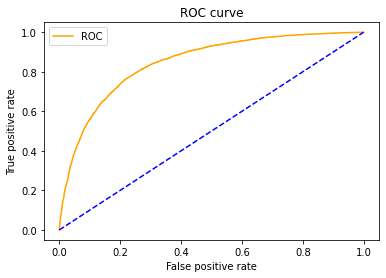




Area under the curve:  0.8465208990586173


In [20]:
#calculation of AUC_ROC
xgbr = XGBRegressor(learning_rate= 0.05 , max_depth= 5, n_estimators= 300 )
xgbr.fit(x_train,y_train)
y_pred = xgbr.predict(x_test)
fpr, tpr, threshhold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plot_roc_curve(fpr, tpr) 
print('\n\n')
print('Area under the curve: ', roc_auc_score(y_test, y_pred))

In [23]:
#prediction for the target> using test data
prep_tf_new = prep_tf.select_dtypes(include=np.number)
y_new = xgbr.predict(prep_tf_new)
prep_tf['diabetes_mellitus'] = y_new
prep_tf['encounter_id'] = test_df.copy().encounter_id.values
prep_tf.head()

test_id = prep_tf.copy().encounter_id.values
test_preds = prep_tf.diabetes_mellitus.values
submission = pd.DataFrame.from_dict({
    'encounter_id':test_id,
    'diabetes_mellitus':test_preds,
})

submission.to_csv('submission.csv', index=False)


submission = pd.read_csv('submission.csv')
submission.head()


from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Private Leaderboard Score- 0.84758
#Public Leaderboard Score- 0.84048